# Methods for Data Science CW 3

In [5]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sbn

## 1

In [6]:
feature_mat = np.loadtxt(open("Task1/feature_matrix.csv", "rb"), delimiter=",")
adj_mat = np.loadtxt(open("Task1/adjacency_matrix.csv", "rb"), delimiter=",")

## 1.1 Clustering of the feature matrix (15 marks)
Find optimised clusterings of the feature matrix F by running the k-means algorithm for all values of k in the interval [2, 30]. Plot the Calinski-Harabasz (CH) score to evaluate the quality of clusterings as a function of k, and pick the first clustering with CH < 7 as your 'optimal' clustering. Report some of the characteristics of this 'optimal' clustering (e.g., distribution of cluster sizes; within group and across group similarities; or any other relevant statistics or descriptors of the clustering at your discretion). 

Discuss the meaning of the CH score and evaluate the quality of the 'optimal' clustering you found according to other quality measures from the literature.

Evaluate the robustness of your results given the randomness of k-means optimisation.

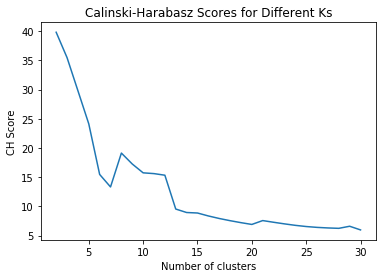

In [7]:
X = feature_mat

CHs = []
optimal = 0

for i in range(2, 31):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    ch = metrics.calinski_harabasz_score(X, labels)
    CHs.append(ch)
    if optimal == 0 and ch < 7:
        optimal = i
        
plt.plot(range(2, 31), CHs)
plt.title('Calinski-Harabasz Scores for Different Ks')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=optimal, random_state=0)
kmeans.fit(X)
print(f"The first k with a CH score under 7 is {optimal}")

The first k with a CH score under 7 is 20


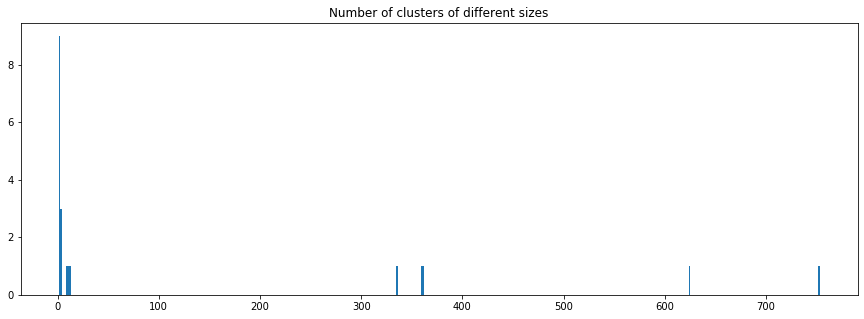

In [9]:
def cluster_sizes(model):
    labels = model.labels_
    sizes = {}
    for c in set(labels):
        sizes[c] = (labels == c).sum()
    return sizes

sizes = cluster_sizes(kmeans)
plt.figure(figsize=(15, 5))
plt.hist(sizes.values(), 500)
plt.title("Number of clusters of different sizes")
plt.show()

In [10]:
silhouette_score = metrics.silhouette_score(X, kmeans.labels_)
davies_bouldin = metrics.davies_bouldin_score(X, kmeans.labels_)
print(f"The silhouette score for this model: {silhouette_score}")
print(f"The davies-bouldin index for this model: {davies_bouldin}")


The silhouette score for this model: -0.0327015809891909
The davies-bouldin index for this model: 2.8500784953512026


CH: Variance Ratio Criterion - where a higher Calinski-Harabasz score relates to a model with better defined clusters

The score is fast to compute
The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters


Silhouette

The best silhouette score value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters


This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.


**add mathematical formulations**
https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation

## 1.2 Analysis of the citation graph (10 marks)
Use NetworkX to display the citation graph described by the adjacency matrix, A. Plot the degree distribution of the graph as a histogram. 

Compute the following three centrality measures for all the nodes of the graph: (i) degree; (ii) betweenness centrality; (iii) Pagerank. Study which nodes (if any) are highly central according to the three measures.

Using appropriate correlation plots (or otherwise), discuss the similarity between the node rankings according to the different centrality measures and explain why the centrality rankings might differ.

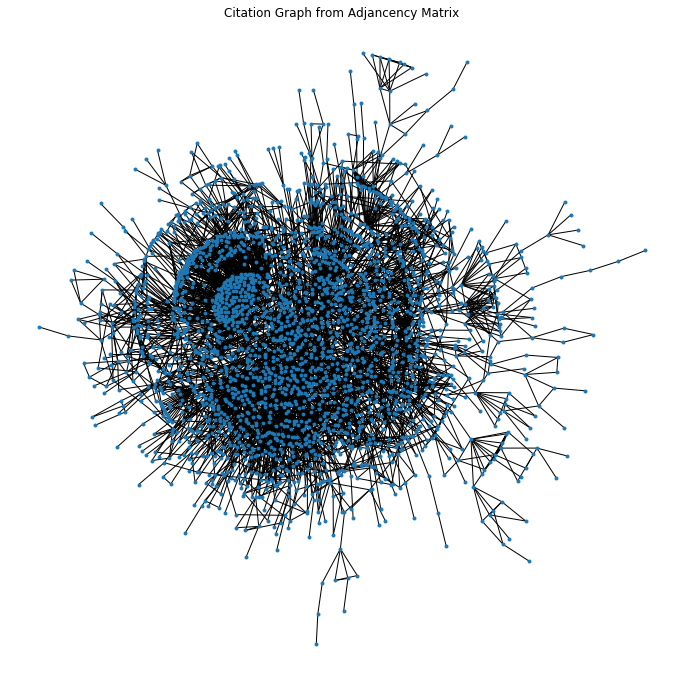

In [11]:
G = nx.from_numpy_matrix(adj_mat)

plt.figure(figsize=(12,12)) 
plt.title("Citation Graph from Adjancency Matrix")
nx.draw_kamada_kawai(G,node_size=15, with_labels=False, linewidths=0.05)
plt.show()

The max degree in the graph is: 168


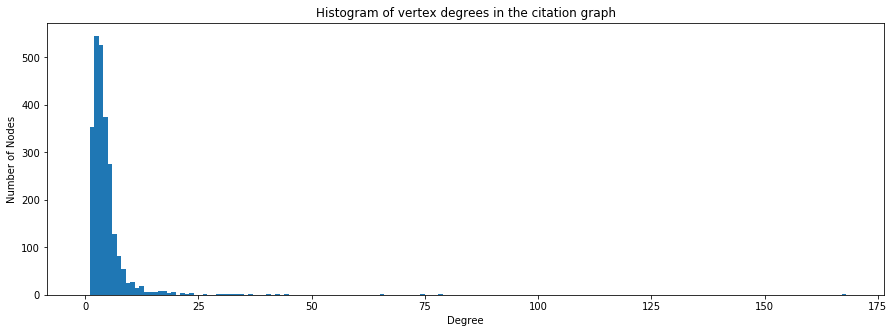

In [12]:
degrees = G.degree()

degrees_val = [d for (v,d) in degrees]
print(f"The max degree in the graph is: {max(degrees_val)}")
plt.figure(figsize=(15,5)) 
plt.title("Histogram of vertex degrees in the citation graph")
plt.hist(degrees_val, range(0, max(degrees_val)+1))
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.show()

In [13]:
degrees = G.degree()
b_centrs = nx.betweenness_centrality(G)
pageranks = nx.pagerank(G)

In [16]:
measures = pd.DataFrame(degrees, columns=['node', 'degree'])
measures['between_centr']= measures['node'].map(b_centrs)
measures['pagerank']= measures['node'].map(pageranks)
measures = measures.sort_values('degree', ascending=False)
measures.head(5)

,node,degree,between_centr,pagerank
1245,1245,168,0.276114,0.013302
271,271,78,0.090707,0.005511
1563,1563,74,0.101355,0.006811
1846,1846,65,0.149763,0.005833
1672,1672,44,0.062338,0.003957


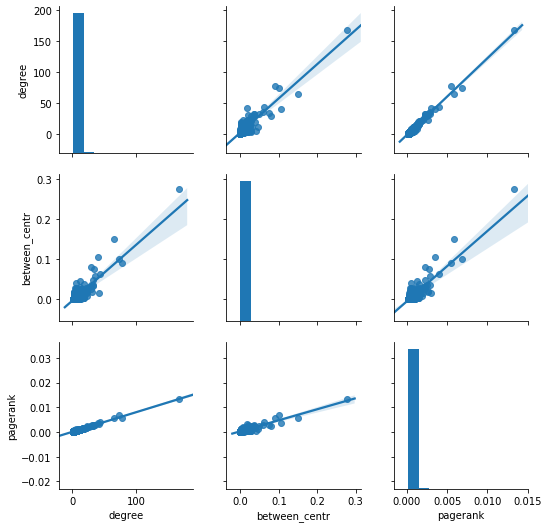

In [17]:
g = sbn.pairplot(measures[['degree', 'between_centr', 'pagerank']], kind='reg')

# Analysis

## 1.3 Community detection on the citation graph (10 marks)
Use the Clauset-Newman-Moore greedy modu- larity maximisation algorithm in Networkx to compute the optimal number of communities k* and the correspond- ing partition of the citation graph.

Plot the obtained clusters on the NetworkX graph you obtained in 1.2 by assigning different colours to the nodes in each community.

Study how the top 30 most central nodes according to degree and Pagerank computed in 1.2 are distributed across your k* communities. Explain your findings.

In [18]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

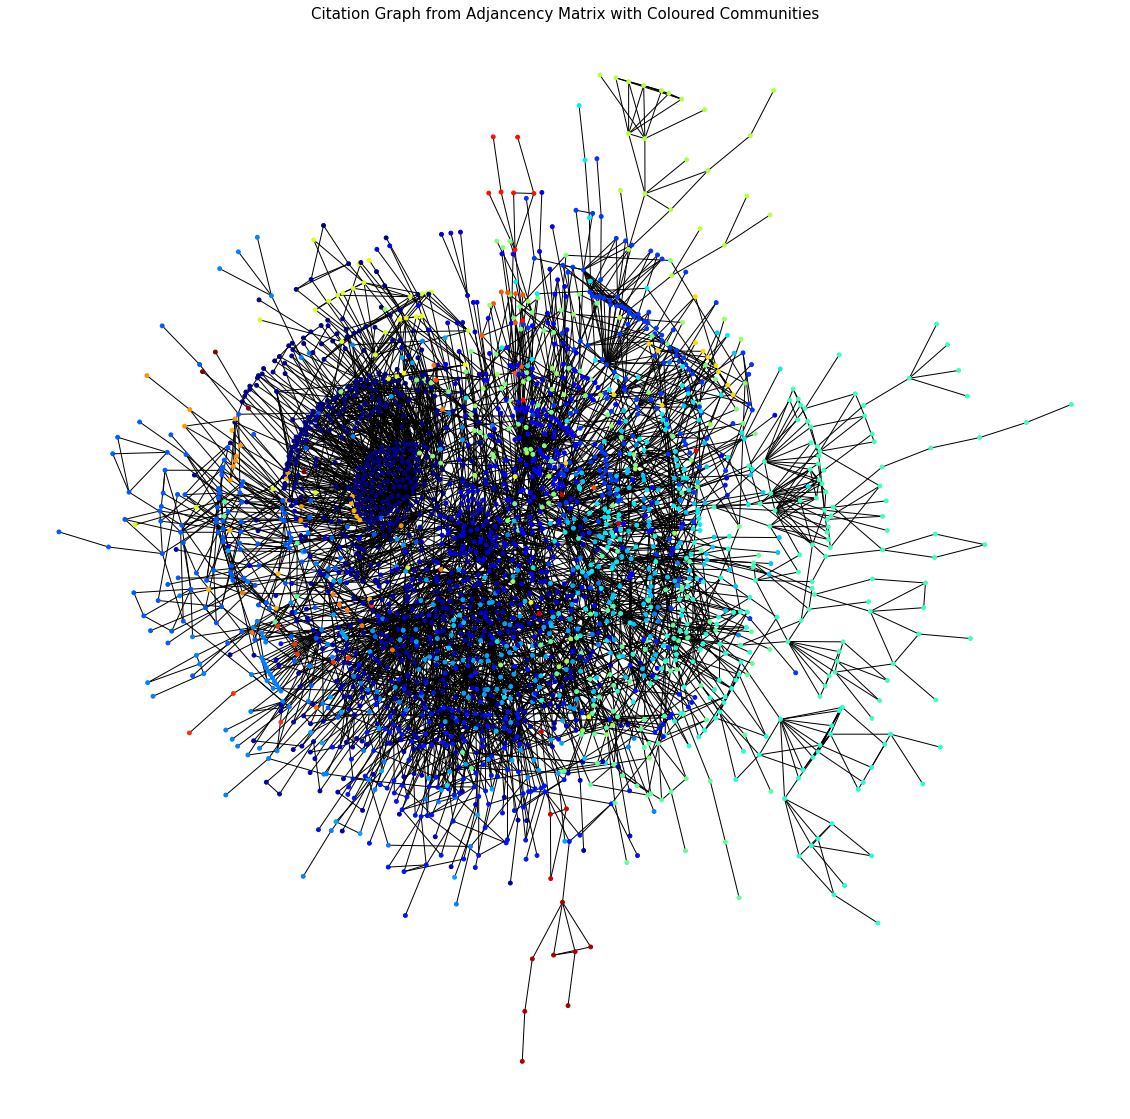

In [19]:
values = [0]* len(G.nodes())
for num, comm in enumerate(communities):
    for node in comm:
        values[node] = num

plt.figure(figsize=(20,20)) 
plt.title("Citation Graph from Adjancency Matrix with Coloured Communities", size=15)
nx.draw_kamada_kawai(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=15,
                     with_labels=False)
plt.show()

In [20]:
comm_measures = measures
comm_measures['community'] = values

max_degrees = comm_measures.sort_values('degree', ascending=False)[['degree', 'community']][:30]
max_pagerank = comm_measures.sort_values('pagerank', ascending=False)[['pagerank', 'community']][:30]

In [21]:
print([len(c) for c in communities])

[391, 307, 199, 183, 166, 149, 115, 115, 114, 108, 102, 95, 92, 82, 71, 38, 25, 21, 13, 13, 13, 13, 11, 11, 9, 9, 8, 8, 4]


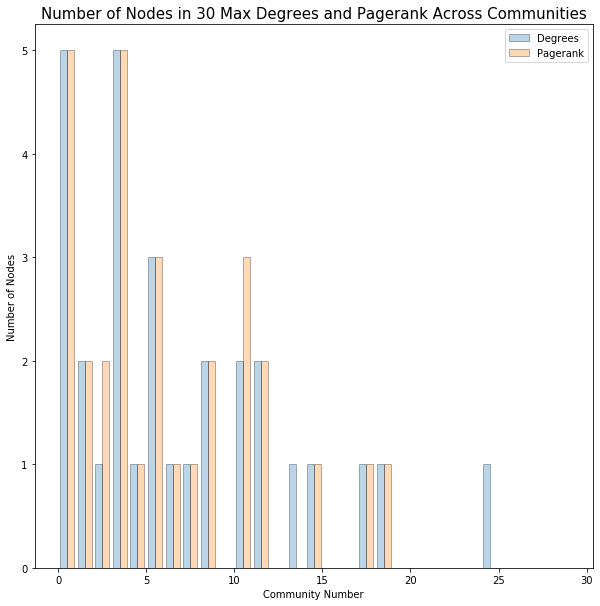

In [22]:
bins = range(0,30)
plt.figure(figsize=(10,10)) 
plt.title("Number of Nodes in 30 Max Degrees and Pagerank Across Communities", size=15)
plt.hist([max_degrees['community'], max_pagerank['community']], bins, 
         alpha=0.3, label=['Degrees', 'Pagerank'], edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Community Number')
plt.ylabel('Number of Nodes')
plt.show()

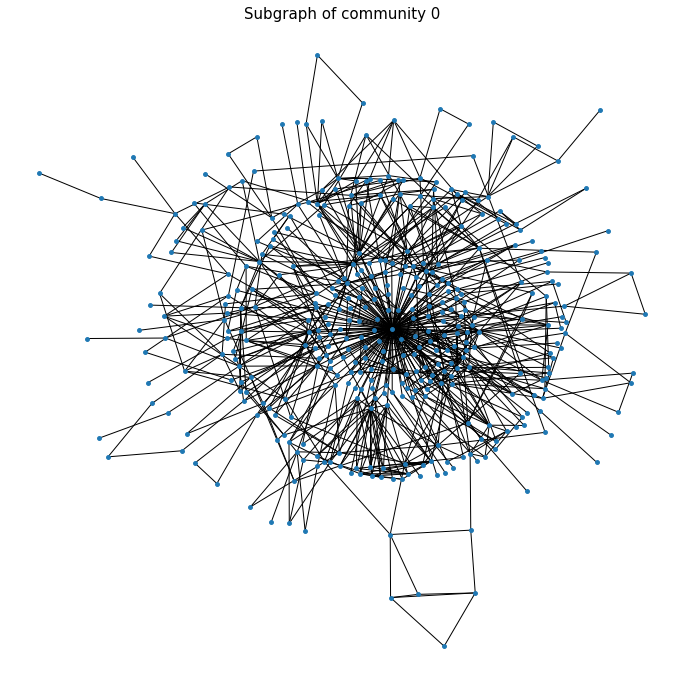

In [23]:
G_0 = G.subgraph(communities[0])
plt.figure(figsize=(12,12)) 
plt.title("Subgraph of community 0", size=15)
nx.draw_kamada_kawai(G_0, node_size=15, with_labels=False)
plt.show()

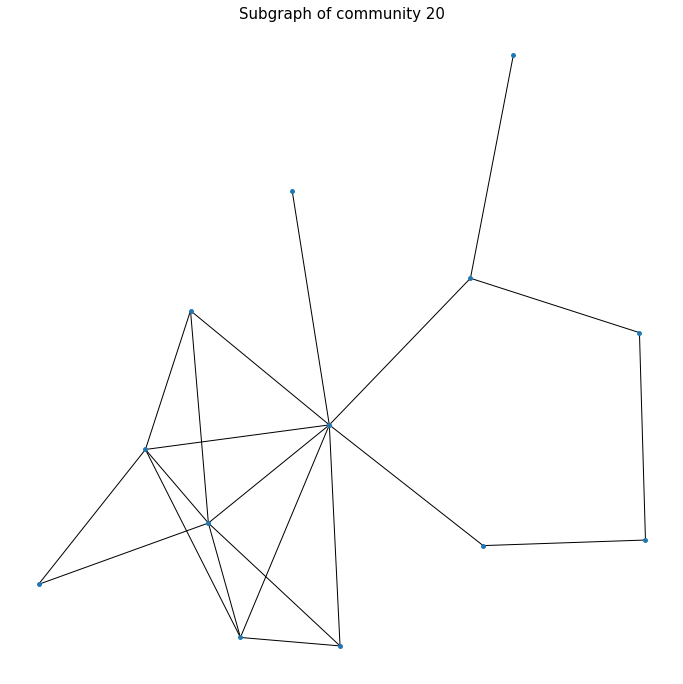

In [24]:
G_20 = G.subgraph(communities[20])
plt.figure(figsize=(12,12)) 
plt.title("Subgraph of community 20", size=15)
nx.draw_kamada_kawai(G_20, node_size=15, with_labels=False)
plt.show()

## 1.4 Compare feature and graph clusterings (10 marks)
Use Adjusted Mutual Information (AMI) and Adjusted Rand Index (ARI) to score how similar the optimal clusterings obtained in 1.1 and 1.3 are to each other.

Plot the clusters you obtained in 1.1 onto the NetworkX graph you generated in 1.2 so that you can compare visually the feature clusters in 1.1 to the graph-based communities in 1.3.

Based on the above, discuss the similarities and differences you observe. You can use other metrics or other visualisation methods to compare the two optimal clusterings at your discretion, explaining your choices.

In [27]:
AMI = metrics.adjusted_mutual_info_score(kmeans.labels_, values)
print(AMI)

ARI = metrics.adjusted_rand_score(kmeans.labels_, values)
print(ARI)

0.12167113951301722
0.05473621929641328


## 2.1 Unsupervised clustering of the image dataset (20 marks)
Use the k-means algorithm in sklearn in an unsupervised manner (i.e., without using any 'ground truth' labels) to cluster the Fashion-MNIST dataset (just the 'training' part) into k classes, for all values of k between k=2 and k=30. Give some thought to how to deal with the inherent randomness of the output of the k-means algorithm.

Do you find any evidence of the existence of 10 classes in the data? Support your explanation using some of the measures you discussed in Task 1.1, or otherwise using other unsupervised clustering methods described in class. Support your explanations with figures, computations and mathematical explanations.

Consider the k-means clustering you obtained for k=10. Visualise the centroid of each of the 10 clusters.

Use the k-means clustering with k=10 as a kNN classifier for the test set. Report its accuracy and any other quality measures of its performance.

In [31]:
fashion_data = pd.read_csv("Task2/fashion-mnist_train.csv")

In [38]:
y = fashion_data['label']
X = fashion_data[fashion_data.columns[1:]]

In [39]:
f_CHs = []
f_optimal = 0

for i in range(2, 31):
    f_kmeans = KMeans(n_clusters=i, random_state=0)
    f_kmeans.fit(X)
    labels = f_kmeans.labels_
    ch = metrics.calinski_harabasz_score(X, labels)
    f_CHs.append(ch)
    if optimal == 0 and ch < 7:
        optimal = i
        
plt.plot(range(2, 31), f_CHs)
plt.title('Calinski-Harabasz Scores for Different Ks')
plt.xlabel('Number of clusters')
plt.ylabel('CH Score')
plt.show()

KeyboardInterrupt: 

## 2.2 Supervised classification of the training set (25 marks)
### 2.2.1 MLP neural network supervised classification: 
Using PyTorch, implement a multilayer perceptron (MLP) to classify the images of the dataset into the 10 classes. For this task, you will need to vectorise your images so that they can be used as inputs.

Setup of the network: Your MLP will have a number of input nodes equal to the number of pixels in each im- age, three hidden layers, each with 100 nodes, and an output layer with 10 nodes corresponding to the num- ber of classes. You should use ReLU as your activation function with no dropout.

For the training, you should use a negative log-likelihood loss, a learning rate of 0.005, and stochastic gradi- ent descent (SGD) as the optimisation method. You should train in batches of 128 images for 30 epochs. Note: If using Google Colab, make sure you use its GPUs by selecting in the top menu 'Edit > Notebook set- tings > Hardware accelerator > GPU'.
Compute the accuracy of this MLP classifier on the test set and report any other quality measures of its per- formance. No optimisation of hyperparameters is necessary.

### 2.2.2 Convolutional neural network (CNN) supervised classification
Using PyTorch, build a small CNN to classify the images of the dataset into the 10 classes.

Setup of the network: Your CNN should have the following architecture:
![222archi](222archi.png)
  You should choose ReLU as the activation functions, reduce the dimensionality of the feature maps by a sub- sampling layer where the highest value in each subsampled feature map is chosen, implement a stride of 2 into these pooling layers, and have a kernel size of 5 in all convolutional layers. The stride and the dilation in the convolutional layers should be both 1. All other hyperparameters and options remain as in 2.2.1.
  
Note: If using Google Colab, make sure you use its GPUs by selecting in the top menu 'Edit > Notebook set- tings > Hardware accelerator > GPU'.

Compute the accuracy of this CNN classifier on the test set and report any other quality measures of its per- formance.

### 2.2.3 Comparisons of the classifiers
Compare the performance of the CNN and MLP classifiers focussing in particular on the difference in the number of parameters in both models. Explain the observed difference in performance given the different operations on the data carried out by the MLP and CNN models.
Compare the performance of both supervised classifiers to the k-NN classifier obtained in 2.1 from the unsu- pervised k-means clustering. Discuss the outcomes given the distinct approaches used in supervised and unsupervised learning.

Using 5-fold cross-validation on the training set, optimise the CNN architecture to increase its accuracy above 90%. You might want to try adding hidden layers, changing the activation function, or any other method you believe could increase the accuracy. Explain your choices and why these changes result in an improvement.

## Task 3: Poster (10 marks)
Prepare a pdf file with a poster to illustrate your work and findings for either Task 1 or Task 2. You are free to choose the format of your poster. The poster should contain a concise description of the data and the problem; a summary of the methods used, and a compilation of your findings and conclusions.

The poster should be concise but clear; should not contain large amounts of text; and use clearly labelled figures and tables obtained with your Python scripts. Keep to message but be clear about your conclusions.

Your target audience would be, e.g., a manager working for Nature Publishing Group (for Task 1) or a manager working for Zara or Uniqlo (for Task 2), looking to hire a data scientist to join their company. There is more guidance on the poster at the end of the Coursework.

## 4.1 Comparing PCA and NMF dimensionality reduction
Use principal component analysis (PCA) and non- negative matrix factorisation (NMF) to reduce the dimensionality of the Fashion-MNIST dataset (just the 'training' part) to the top 10 'components'. For each of the two methods, visualise each of the 10 components and study quantitatively how they are related to the 10 classes in the data. Use your computations to explain the differ- ences between the PCA and NMF representations in terms of the sparsity of the corresponding components and the correspondence of the components to visual features (see NMF original paper by Lee and Seung).

## 4.2 Latent Dirichlet Allocation (LDA) applied to images
Latent Dirichlet allocation (LDA) is a method intro- duced by Blei, Ng and Jordan, which is widely used in Natural Language Processing (NLP) to analyse collec- tions of text documents (like the one you were given in Task 1) to group documents into 'topics' according to their similarity. You should read the description of LDA in the literature.

Making the following analogies (document→image, word→pixel), apply LDA to the Fashion-MNIST dataset (just the 'training' part) in order to find 10 'topics' corresponding to groups of images that display high similarities.

Visualise each of the centroids of the 10 groups you found using LDA and compare them with those found in 4.1 and 2.1. Would you expect LDA to work on this problem? Give some reasons based on your reading of the method.